In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Configure character display
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# Define column names
cols = ['label'] + [f'I{i}' for i in range(1, 14)] + [f'C{i}' for i in range(1, 27)]

cat_features = [f'C{i}' for i in range(1, 27)]  # Numerical features

# Load data (first 10,000 rows)
data = pd.read_csv('../../data/raw/train.txt', sep='\t', header=None, names=cols, nrows=10000)

,Feature,Total Samples,Missing Samples,Missing Ratio (%),Cardinality (Number of Categories),Cardinality Rank
1,C20,"10,000","4,496",44.96,3,1
2,C9,"10,000",0,0.00,3,1
3,C22,"10,000","8,182",81.82,7,3
4,C6,"10,000","1,332",13.32,7,3
5,C17,"10,000",0,0.00,9,5
6,C23,"10,000",0,0.00,12,6
7,C14,"10,000",0,0.00,24,7
8,C25,"10,000","4,496",44.96,39,8
9,C5,"10,000",0,0.00,56,9
10,C8,"10,000",0,0.00,93,10


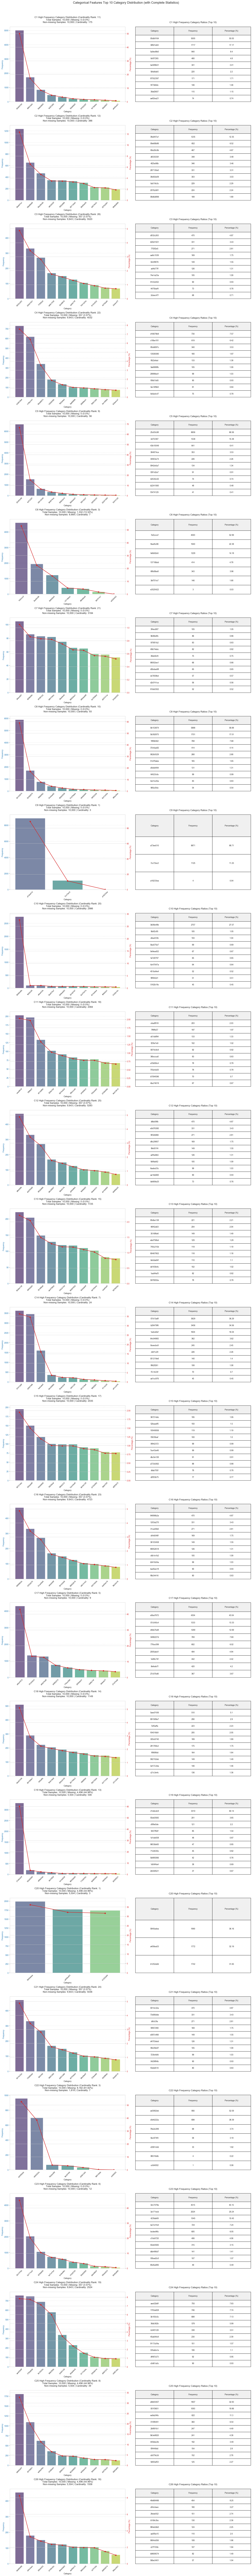


Analysis Tips:
1. A smaller cardinality rank indicates fewer categories for that feature (simpler feature)
2. Combining cardinality rank and category distribution helps develop better encoding strategies:
   - Top 5 cardinality ranks (few categories): Suitable for one-hot encoding
   - Bottom 5 cardinality ranks (many categories): Suitable for target encoding or embedding
3. The number of non-missing samples reflects data completeness; low values indicate severe missingness
4. Features with missing ratios exceeding 50% may need evaluation for retention


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.table import Table
from IPython.display import display

# Categorical Feature Analysis:

# Total number of samples (total rows in dataset)
total_dataset_samples = len(data)

# ====================
# 1. Calculate complete statistics for all features and rank them
# ====================
# Initialize storage list
stats_list = []

for feature in cat_features:
    # Calculate various statistical indicators
    non_missing_samples = data[feature].dropna().shape[0]  # Number of non-missing samples
    missing_samples = total_dataset_samples - non_missing_samples  # Number of missing samples

    # Calculate missing ratio with rounding
    missing_ratio = round((missing_samples / total_dataset_samples * 100), 2)  # Missing ratio

    cardinality = data[feature].nunique()  # Cardinality (number of distinct categories)

    # Store results
    stats_list.append({
        'Feature': feature,
        'Total Samples': total_dataset_samples,
        'Missing Samples': missing_samples,
        'Missing Ratio (%)': missing_ratio,
        'Cardinality (Number of Categories)': cardinality
    })

# Convert to DataFrame and calculate rankings
stats_df = pd.DataFrame(stats_list)
# Rank by cardinality in ascending order (1 indicates smallest cardinality)
stats_df['Cardinality Rank'] = stats_df['Cardinality (Number of Categories)'].rank(method='min').astype(int)
# Sort by cardinality rank and add index (starting from 1)
stats_df = stats_df.sort_values('Cardinality Rank').reset_index(drop=True)
stats_df.index = stats_df.index + 1  # Index starts from 1

# Display complete cardinality ranking table
display(stats_df.style.set_caption("Categorical Feature Statistics Ranking (by Cardinality Ascending)")
.background_gradient(subset=['Cardinality (Number of Categories)'], cmap='YlOrRd')
.background_gradient(subset=['Missing Ratio (%)'], cmap='Reds')
.format({
    'Total Samples': '{:,}',
    'Missing Samples': '{:,}',
    'Missing Ratio (%)': '{:.2f}',
    'Cardinality (Number of Categories)': '{:,}'
}))

# ====================
# 2. Visualize Top 10 categories for each feature (with row spacing)
# ====================
# Display 1 feature per row (chart on left, table on right)
rows_needed = len(cat_features)
fig, axes = plt.subplots(rows_needed, 2, figsize=(18, 7 * rows_needed))

# Iterate through each categorical feature
for i, feature in enumerate(cat_features):
    # Get statistical data for current feature
    feature_stats = stats_df[stats_df['Feature'] == feature].iloc[0]
    total_samples = feature_stats['Total Samples']
    missing_samples = feature_stats['Missing Samples']
    missing_ratio = feature_stats['Missing Ratio (%)']
    total_categories = feature_stats['Cardinality (Number of Categories)']
    cardinality_rank = feature_stats['Cardinality Rank']
    non_missing = total_samples - missing_samples  # Number of non-missing samples

    # Calculate Top 10 categories and their proportions (based on non-missing samples)
    feature_data = data[feature].dropna()
    counts = feature_data.value_counts()
    top10 = counts.head(10)

    # Calculate ratio with rounding
    top10_ratio = round((top10 / len(feature_data) * 100), 2)  # Convert to percentage

    # Create statistical table data
    table_data = pd.DataFrame({
        'Category': top10.index.astype(str),
        'Frequency': top10.values,
        'Percentage (%)': top10_ratio.values
    })

    # ====================
    # Left: Bar chart + ratio line chart
    # ====================
    ax_chart = axes[i, 0]

    # 1. Plot bar chart (frequency)
    sns.barplot(
        x=top10.index,
        y=top10.values,
        ax=ax_chart,
        hue=top10.index,
        palette='viridis',
        legend=False,
        alpha=0.7
    )
    ax_chart.set_xlabel('Category', fontsize=10)
    ax_chart.set_ylabel('Frequency', fontsize=10, color='tab:blue')
    ax_chart.tick_params(axis='x', rotation=45, labelsize=9)
    ax_chart.tick_params(axis='y', labelcolor='tab:blue')
    ax_chart.grid(axis='y', linestyle='--', alpha=0.7)

    # 2. Create second y-axis, plot line chart (percentage)
    ax_line = ax_chart.twinx()
    ax_line.plot(
        top10.index,
        top10_ratio.values,
        color='tab:red',
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=6
    )
    ax_line.set_ylabel('Percentage (%)', fontsize=10, color='tab:red')
    ax_line.tick_params(axis='y', labelcolor='tab:red')
    ax_line.set_ylim(0, max(top10_ratio.values) * 1.1)  # Set percentage axis range

    # Set chart title (including complete statistical information)
    ax_chart.set_title(
        f'{feature} High Frequency Category Distribution (Cardinality Rank: {cardinality_rank})\n'
        f'Total Samples: {total_samples:,} | Missing: {missing_samples:,} ({missing_ratio}%)\n'
        f'Non-missing Samples: {non_missing:,} | Cardinality: {total_categories}',
        fontsize=12,
        pad=20  # Increase spacing between title and chart
    )

    # ====================
    # Right: Percentage table
    # ====================
    ax_table = axes[i, 1]
    ax_table.axis('off')  # Turn off coordinate axes

    # Create table
    table = Table(ax_table, bbox=[0, 0, 1, 1])

    # Add table headers
    headers = table_data.columns
    for col_idx, header in enumerate(headers):
        table.add_cell(0, col_idx, width=0.3, height=0.1,
                       text=header, loc='center', facecolor='#f0f0f0')

    # Add table content
    for row_idx in range(len(table_data)):
        for col_idx in range(len(headers)):
            table.add_cell(row_idx + 1, col_idx, width=0.3, height=0.08,
                           text=str(table_data.iloc[row_idx, col_idx]),
                           loc='center')

    # Add table to axis
    ax_table.add_table(table)

    # Add table title
    ax_table.text(0.5, 1.05, f'{feature} High Frequency Category Ratios (Top 10)',
                  horizontalalignment='center', fontsize=12,
                  transform=ax_table.transAxes)

# Adjust row spacing
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.suptitle('Categorical Features Top 10 Category Distribution (with Complete Statistics)', fontsize=16, y=1.005)
plt.show()

# Analysis conclusion prompts
print("\nAnalysis Tips:")
print("1. A smaller cardinality rank indicates fewer categories for that feature (simpler feature)")
print("2. Combining cardinality rank and category distribution helps develop better encoding strategies:")
print("   - Top 5 cardinality ranks (few categories): Suitable for one-hot encoding")
print("   - Bottom 5 cardinality ranks (many categories): Suitable for target encoding or embedding")
print("3. The number of non-missing samples reflects data completeness; low values indicate severe missingness")
print("4. Features with missing ratios exceeding 50% may need evaluation for retention")
